In [160]:
import os
import scipy.stats as stats
import pandas as pd
import numpy as np
import tqdm
from collections import defaultdict

In [55]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [85]:
color_palette = {
    'H:H': "tab:blue",
    'A:A': "tab:red",
    'H:A': "grey"
}

In [7]:
AVAILBLE_DATASETS = ['DIALOG_pc.csv','DIALOG_tc.csv','FLICKR.csv','MLQE.csv','REAL_SUM.csv',
                     'SUM_EVAL.csv','TAC_08.csv','TAC_09.csv','TAC_11.csv']
DATA_PATH = 'final_df'

In [10]:
def load_csv(dataset):
    return pd.read_csv(os.path.join(DATA_PATH, dataset)).set_index(['System','Utterance'])

In [211]:
datasets = {}
for d in AVAILBLE_DATASETS:
    datasets[d] = load_csv(d)

In [207]:
sum_eval_df = load_csv('TAC_08.csv')
sum_eval_df.head()

H:pyr  H:resp    S3_pyr   S3_resp  ROUGE_WE_1  ROUGE_WE_2  \
System Utterance                                                              
0      M0         0.263     0.4  0.266698  0.407509    0.340102    0.166667   
       M1         0.316     0.4  0.387789  0.483211    0.403553    0.238462   
       M2         0.263     0.4  0.456964  0.544256    0.439086    0.264103   
       M3         0.289     0.4  0.360855  0.468622    0.408629    0.246154   
       M4         0.342     0.4  0.315286  0.433800    0.365482    0.205128   

                      JS_1      JS_2   ROUGE_L   ROUGE_1   ROUGE_2       BLEU  \
System Utterance                                                                
0      M0        -0.499253 -0.627760  0.192893  0.345178  0.097436  11.887466   
       M1        -0.454826 -0.596727  0.228426  0.416244  0.138462  23.964261   
       M2        -0.428838 -0.566805  0.304569  0.456853  0.179487  36.476664   
       M3        -0.483798 -0.593334  0.228426  0.401015  0.148718  30.983069   
       M4        -0.489856 -0.611463  0.210660  0.375635  0.112821  11.968042   

                    Chrfpp  BERTScore  MoverScore  
System Utterance                                   
0      M0         0.362953   0.586744    0.145967  
       M1         0.419907   0.619727    0.147530  
       M2         0.531733   0.635817    0.211053  
       M3         0.411381   0.586946    0.119991  
       M4         0.424539   0.588133    0.144689

In [39]:
def compute_system_correlation(df, m_a, m_b, metric='tau'):
    m_a_agg = df[m_a].groupby('System').mean().values
    m_b_agg = df[m_b].groupby('System').mean().values
    if metric == 'tau':
        return stats.kendalltau(m_a_agg, m_b_agg)[0]
    elif metric == 'rho':
        return stats.spearmanr(m_a_agg, m_b_agg)[0]
    return stats.pearsonr(m_a_agg, m_b_agg)[0]

def compute_instance_correlation(df, m_a, m_b, metric='tau'):
    corr = []
    for (_, df_a),(_,df_b) in zip(df[m_a].groupby(level=0), df[m_b].groupby(level=0)):
        if metric == 'tau':
            corr.append(stats.kendalltau(df_a.values, df_b.values)[0])
        elif metric == 'rho':
            corr.append(stats.spearmanr(df_a.values, df_b.values)[0])
        else:
            corr.append(stats.pearsonr(df_a.values, df_b.values)[0])
    
    return np.nanmean(corr)

In [40]:
def average_pairwise(df, group_metrics_a, group_metrics_b, metric='tau', level='system'):
    average = []
    for m_a in group_metrics_a:
        for m_b in group_metrics_b:
            if m_a == m_b:
                continue
            if level == 'system':
                corr = compute_system_correlation(df, m_a, m_b, metric)
            else:
                corr = compute_instance_correlation(df, m_a, m_b, metric)
            average.append(corr)
    return np.nanmean(average)

In [202]:
def average_distances(df, bootstrap=20, metric='tau', level='system'):
    humans = [v for v in df.columns if v.startswith('H:')]
    automatic = [v for v in df.columns if not v.startswith('H:')]
    
    baseline_corr = average_pairwise(df, df.columns, df.columns, metric=metric, level=level)
    h_h, a_a, a_h = [], [], []
    for _ in tqdm.tqdm(range(bootstrap)):
        if bootstrap == 1:
            resampled_df = df
        else:
            resampled_df = df.sample(frac=1, replace=True)
        h_h.append(average_pairwise(resampled_df, humans, humans, metric=metric, level=level) / baseline_corr)
        a_a.append(average_pairwise(resampled_df, automatic, automatic, metric=metric, level=level) / baseline_corr)
        a_h.append(average_pairwise(resampled_df, automatic, humans, metric=metric, level=level) / baseline_corr)
    
    return {
        'H:H': {'Correlation': np.mean(h_h), 'Low-CI': np.quantile(h_h, q=0.05), 'High-CI': np.quantile(h_h, q=0.95)},
        'A:A': {'Correlation': np.mean(a_a), 'Low-CI': np.quantile(a_a, q=0.05), 'High-CI': np.quantile(a_a, q=0.95)},
        'H:A': {'Correlation': np.mean(a_h), 'Low-CI': np.quantile(a_h, q=0.05), 'High-CI': np.quantile(a_h, q=0.95)}
    }

In [78]:
avg_distance_dicts = {}
for dataset in AVAILBLE_DATASETS:
    print(f'Processing {dataset}')
    df = load_csv(dataset)
    avg_distance_dicts[dataset] = average_distances(df)

Processing DIALOG_pc.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.37it/s]


Processing DIALOG_tc.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]


Processing FLICKR.csv


  0%|                                                                                                                                                  | 0/100 [00:00<?, ?it/s]/var/folders/lr/_9h15b252l5b5y3dkq6ngvpw0000gp/T/ipykernel_37644/555243868.py:12: RuntimeWarning: Mean of empty slice
  return np.nanmean(average)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.17it/s]


Processing MLQE.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.47it/s]


Processing REAL_SUM.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.49it/s]


Processing SUM_EVAL.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.59it/s]


Processing TAC_08.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.49it/s]


Processing TAC_09.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.33it/s]


Processing TAC_11.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.28it/s]


In [203]:
avg_distance_instance_dicts = {}
for dataset in AVAILBLE_DATASETS:
    print(f'Processing {dataset}')
    df = load_csv(dataset)
    avg_distance_instance_dicts[dataset] = average_distances(df, level='instance')

Processing DIALOG_pc.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:19<00:00,  6.97s/it]


Processing DIALOG_tc.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:32<00:00,  7.63s/it]


Processing FLICKR.csv


  0%|                                                                                                                                                   | 0/20 [00:00<?, ?it/s]/var/folders/lr/_9h15b252l5b5y3dkq6ngvpw0000gp/T/ipykernel_37644/555243868.py:12: RuntimeWarning: Mean of empty slice
  return np.nanmean(average)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:01<00:00,  9.10s/it]


Processing MLQE.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [15:46<00:00, 47.31s/it]


Processing REAL_SUM.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:56<00:00, 11.80s/it]


Processing SUM_EVAL.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:23<00:00, 13.17s/it]


Processing TAC_08.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.39s/it]


Processing TAC_09.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:39<00:00,  4.99s/it]


Processing TAC_11.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:01<00:00,  6.10s/it]


In [204]:
legend_names = {
    'H:H': 'Human-Human',
    'A:A': 'Auto-Auto',
    'H:A': 'Human-Auto'
}

def plot_avg_distance(ax, average_distance_dict, ylabel='correlation'):
    legend = []
    values = []
    errors = []
    for t, res in average_distance_dict.items():
        legend.append(legend_names[t])
        m = res['Correlation']
        values.append(m)
        errors.append([m - res['Low-CI'], res['High-CI'] - m])
    
    errors = np.array(errors).T
    x = np.arange(len(legend))
    w = 0.7
    rects1 = ax.bar(x, values, yerr=errors, 
                    width=w, alpha=0.8,
                    color=color_palette.values(),
                    error_kw=dict(lw=2, capsize=2, capthick=2))
    
    ax.set_xticks(x)
    ax.set_xticklabels(legend)
    
    ax.axhline(0, ls='--', color='black')
    
    ax.set_ylim((-0.2, 2.4))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel('')

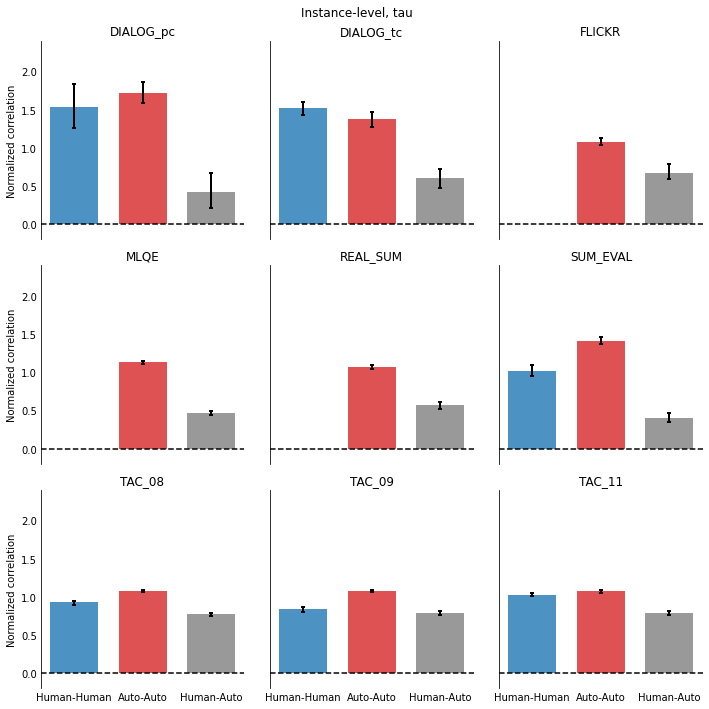

In [206]:
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharey=True, sharex=True)
for i, dataset in zip(range(9), AVAILBLE_DATASETS):
    i_x = int(np.floor(i / 3.))
    i_y = i % 3
    ax = axes[i_x][i_y]
    res = avg_distance_instance_dicts[dataset]
    ylabel = ('' if i_y != 0 else 'Normalized correlation')
    plot_avg_distance(ax, res, ylabel)
    if i_x != 2:
        ax.get_xaxis().set_visible(False)
    ax.title.set_text(dataset.split('.')[0])
    ax.tick_params(axis=u'both', which=u'both',length=0)
fig.suptitle('Instance-level, tau')
fig.tight_layout(pad=1.0)

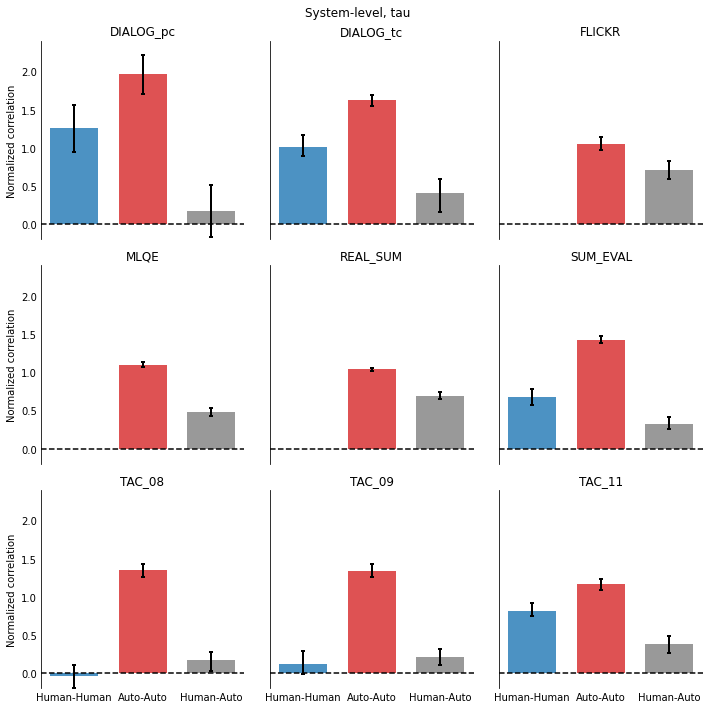

In [205]:
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharey=True, sharex=True)
for i, dataset in zip(range(9), AVAILBLE_DATASETS):
    i_x = int(np.floor(i / 3.))
    i_y = i % 3
    ax = axes[i_x][i_y]
    res = avg_distance_dicts[dataset]
    ylabel = ('' if i_y != 0 else 'Normalized correlation')
    plot_avg_distance(ax, res, ylabel)
    if i_x != 2:
        ax.get_xaxis().set_visible(False)
    ax.title.set_text(dataset.split('.')[0])
    ax.tick_params(axis=u'both', which=u'both',length=0)
fig.suptitle('System-level, tau')
fig.tight_layout(pad=1.0)

Suppose we have Dataframe $D$ for a given dataset.

In this dataframe, we have a set $\cal{M}$ of metrics, some are humans $\cal{H} \subset \cal{M}$ and some are automatic $\cal{A} \subset \cal{M}$.

We denote $\langle \cdot \rangle_{\cal{T}}$ the average taken over metrics in the set of metrics $\cal{T}$, and we compute the following three quantities:

$$\text{H:H} \quad \frac{\langle K(h_i, h_j) \rangle_{h_i, h_j \in \cal{H}}}{\langle K(m_i, m_j) \rangle_{m_i, m_j \in \cal{M}}} $$

$$\text{A:A} \quad \frac{\langle K(a_i, a_j) \rangle_{a_i, a_j \in \cal{A}}}{\langle K(m_i, m_j) \rangle_{m_i, m_j \in \cal{M}}}$$

$$\text{H:A} \quad \frac{\langle K(h_i, a_j) \rangle_{h_i \in\cal{H}, a_j \in \cal{A}}}{\langle K(m_i, m_j) \rangle_{m_i, m_j \in \cal{M}}}$$


The denominator $\langle K(m_i, m_j) \rangle_{m_i, m_j \in \cal{M}}$ is base expected correlation computed on all pairs of metrics.

Then, each quantity measures a specific contribution of the intra-human (H:H), intra-automatoc (A:A) and the cross human-automatic (H:A) correlations.

#### Conclusion from the above plots

- The automatic metrics are much closer to each other than to humans (A:A much higher than H:A and H:H).
- For datasets with more than 2 human metrics, human metrics are also closer to each other than to automatic metrics (H:H higher than H:A for dataset with more than 2 human metrics)

## Global Average
We compute below, the aggregation over all dataset (beware that the aggregation is less meaningful, especially the Confidence Intervals)

In [181]:
def global_average(avg_distance_dicts):
    final_dict = defaultdict(lambda: defaultdict(float))
    for _, dicts in avg_distance_dicts.items():
        for k, v in dicts.items():
            for kk, vv in v.items():
#                 print(f"HERE: {k} {kk} {vv}")
                if not np.isnan(vv):
                    final_dict[k][kk] += vv / len(avg_distance_dicts)
    return final_dict

Text(0.5, 0.98, 'System-level, Tau')

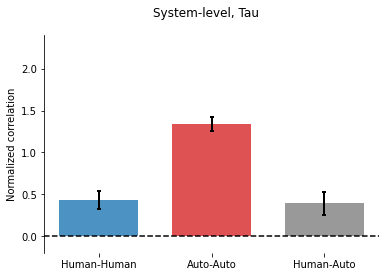

In [209]:
fig, ax = plt.subplots()
f = global_average(avg_distance_dicts)
plot_avg_distance(ax, f, "Normalized correlation")
fig.suptitle("Global Aggregation, System-level, Tau")

Text(0.5, 0.98, 'Global Aggregation Instance-level, Tau')

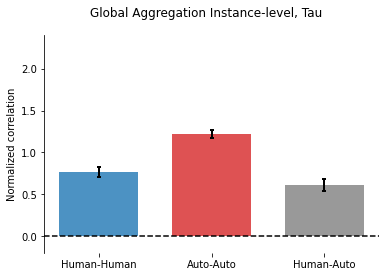

In [210]:
fig, ax = plt.subplots()
f = global_average(avg_distance_instance_dicts)
plot_avg_distance(ax, f, "Normalized correlation")
fig.suptitle("Global Aggregation Instance-level, Tau")

## Measure the influence of each individual system

In previous experiments, we notice that the intra-correlation within automatic metric is much higher than the cross-correlation between automatic metrics and human metrics.
Then, we ask if there some specific systems that are more explanatory for this observed difference. We would like to estimate what is the impact of any given system on this pattern.

To estimate it, we rerun the above experiment but after removing from the Dataframe each system one after the other.
For each system $s$, we then compute the difference $\delta_{s} = H:H - H:A$ when $s$ is removed and compared to the default $\delta$ with all systems included (from the previous experiment). 
For each system $s$, we have a measure of its influence: $\delta_{s} - \delta$, how much of the gap between H:H and H:A is reduced by removing this system $s$.

After that, we make a scatter plot of the influence of system against its human score to see if there is a correlation between system of high influence and their "stength".
When there are several human metrics, we choose the most correlated one (in absolute value)

In [266]:
def measure_system_influence(df, level='system'):
    systems = set(df.index.get_level_values(0).to_list())
    system_effect = {}
    for sys in systems:
        reduced_df = df[df.index.get_level_values(0) != sys]
        res = average_distances(reduced_df, bootstrap=1, level=level)
        system_effect[sys] = res['A:A']['Correlation'] - res['H:A']['Correlation']
    return dict(sorted(system_effect.items(), key=lambda t: t[1]))

In [250]:
sys_effect_dict = {}
for dataset in AVAILBLE_DATASETS:
    print(f'Processing {dataset}')
    df = load_csv(dataset)
    base = (avg_distance_dicts[dataset]['A:A']['Correlation'] - avg_distance_dicts[dataset]['H:A']['Correlation'])
    r = measure_system_influence(df)
    sys_effect_dict[dataset] =  dict((k, v-base) for k, v in r.items())

Processing DIALOG_pc.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


Processing DIALOG_tc.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


Processing FLICKR.csv


  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]/var/folders/lr/_9h15b252l5b5y3dkq6ngvpw0000gp/T/ipykernel_37644/555243868.py:12: RuntimeWarning: Mean of empty slice
  return np.nanmean(average)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


Processing MLQE.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]


Processing REAL_SUM.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.93it/s]


Processing SUM_EVAL.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


Processing TAC_08.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


Processing TAC_09.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]


Processing TAC_11.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.33it/s]


In [ ]:
sys_effect_instance_dict = {}
for dataset in AVAILBLE_DATASETS:
    print(f'Processing {dataset}')
    df = load_csv(dataset)
    base = (avg_distance_instance_dicts[dataset]['A:A']['Correlation'] - avg_distance_instance_dicts[dataset]['H:A']['Correlation'])
    r = measure_system_influence(df, level='instance')
    sys_effect_instance_dict[dataset] =  dict((k, v-base) for k, v in r.items())

Processing DIALOG_pc.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Processing DIALOG_tc.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.43s/it]


Processing FLICKR.csv


  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]/var/folders/lr/_9h15b252l5b5y3dkq6ngvpw0000gp/T/ipykernel_37644/555243868.py:12: RuntimeWarning: Mean of empty slice
  return np.nanmean(average)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.42s/it]


Processing MLQE.csv


  0%|                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

In [263]:
def plot_correlation_score(ax, effect_dict, data):
    dd = datasets[data].groupby('System').mean()
    dd['Influence'] = dd.index.get_level_values(0).map(effect_dict[data])
    metrics = [l for l in dd.columns if l.startswith("H:")]
    most_correlated = (None, 0)
    for h in metrics:
        corr = stats.kendalltau(dd['Influence'], dd[h])[0]
        if np.abs(corr) > most_correlated[1]:
            most_correlated = (h, np.abs(corr))
    print(f"Dataset {data}: Correlation between Influence and most correlated human metric: {most_correlated[1]}")
    dd.plot.scatter(x='Influence', y=most_correlated[0], ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.title.set_text(data)

Dataset DIALOG_pc.csv: Correlation between Influence and most correlated human metric: 0.19769358043387678
Dataset DIALOG_tc.csv: Correlation between Influence and most correlated human metric: 0.11125089589352469
Dataset FLICKR.csv: Correlation between Influence and most correlated human metric: 0.1443298786675558
Dataset MLQE.csv: Correlation between Influence and most correlated human metric: 0.03654454454454455
Dataset REAL_SUM.csv: Correlation between Influence and most correlated human metric: 0.14600614137012635
Dataset SUM_EVAL.csv: Correlation between Influence and most correlated human metric: 0.11805992819100314
Dataset TAC_08.csv: Correlation between Influence and most correlated human metric: 0.14893617021276595
Dataset TAC_09.csv: Correlation between Influence and most correlated human metric: 0.37625993240713185
Dataset TAC_11.csv: Correlation between Influence and most correlated human metric: 0.1114066037110515


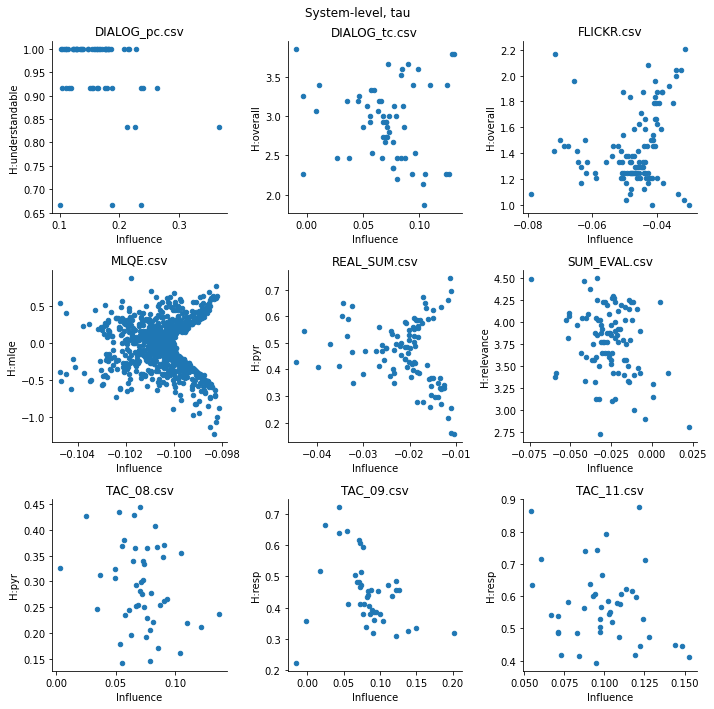

In [264]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
for i, dataset in zip(range(9), AVAILBLE_DATASETS):
    i_x = int(np.floor(i / 3.))
    i_y = i % 3
    ax = axes[i_x][i_y]
    plot_correlation_score(ax, sys_effect_dict, dataset)
fig.suptitle('System-level, tau')
fig.tight_layout(pad=1.0)

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
for i, dataset in zip(range(9), AVAILBLE_DATASETS):
    i_x = int(np.floor(i / 3.))
    i_y = i % 3
    ax = axes[i_x][i_y]
    plot_correlation_score(ax, sys_effect_instance_dict, dataset)
fig.suptitle('Instance-level, tau')
fig.tight_layout(pad=1.0)